## COMP2211 PA1: Text Sentiment Analysis with Naïve Bayes
Welcome to PA1! In this assignment, we will build a **Naïve Bayes Model** to analyze user reviews about Video Games from Amazon. This task is the base for content moderation, user engagement analysis, and surfacing high-quality content in industry.

Although we will not cover **Natural Language Processing (NLP)** in COMP2211, this assignment provides a practical introduction to text analysis, and it's fun to have a taste of it :). Rest assured, we only ask you to implement techniques you've learned in the course.

Your system will perform two key analytical tasks:
1.  **Sentiment Classification**: Build a **Naïve Bayes Classifier** to determine whether reviews are **positive** or **negative**.
2.  **Feature Analysis**: Identify the most important words driving sentiment predictions through log-odds analysis.


#### Part 0: Setup

##### Import libraries

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

##### Check the uploaded data

If you have successfully uploaded the dataset, you should see "dataset.csv" in the output from the code below.

In [2]:
%ls

PA1_2025fall_sol.ipynb      grading/
README.txt*                 old_PA1_2025fall_sol.ipynb*
ZINC_settings:.yml.yml      old_pa1.ipynb*
data/                       pa1_solution.py*
dataset.csv*


##### Import dataset

In [3]:
#Load the public dataset, convert them from pandas dataframe to numpy array
if __name__ == "__main__":
  df_data = pd.read_csv("dataset.csv")
  print(df_data.head())

   rating                   title  \
0       1  don't waste your money   
1       1        Limited run fail   
2       4               It coming   
3       5           A joy to play   
4       5                  awsome   

                                                text  
0                                  not worth a penny  
1  the game itself is wonderful. limited run ruin...  
2  March 15 this character will be released at st...  
3  I usually suck at games like this (first time ...  
4  my grandson covered his xbo and remote in the ...  


As you can see in the output, the dataset includes 3 columns:
1. **Rating**: A float number which could be **1.0, 2.0, 3.0, 4.0, 5.0**. The higher the number, the better the reviewer thinks the game is. However, to ensure that the data has a relatively obvious emotional tendency, we delete those reviews with rating equals to **3.0**. Later in this assignment, we will assign **"positive"** labels to reviews with a rating of 4.0 or 5.0, and **"negative"**labels to the other.
2. **Title** of the review
3. **Text**: Content of the review

##### Text Preprocessing

To ensure our model can process the data efficiently, we need to **preprocess the text** with the following steps:

- Convert all text data to **Strings**.
- Normalize text to **lowercase** to prevent **case sensitivity issues**. e.g., "COMP" vs "comp" would otherwise be treated as different words, which may unnecessarily increase computational complexity and degrade the classification accuracy.
- **Remove punctuation, numbers, and special characters** from the text, so that the model can exclusively on meaningful words for prediction


In [4]:
if __name__ == "__main__":
    # turn all the data into string
    df_data['title'] = df_data['title'].astype(str)
    df_data['text'] = df_data['text'].astype(str)

In [5]:
if __name__ == "__main__":
  # 1. turn into lower cases
  df_data['title'] = df_data['title'].str.lower()
  df_data['text'] = df_data['text'].str.lower()

  # 2. Remove punctuation, numbers, and special characters from the text
  df_data['title'] = df_data['title'].str.replace(r'[^\w\s]', '', regex=True)
  df_data['title'] = df_data['title'].str.replace(r'\d+', '', regex=True)
  df_data['text'] = df_data['text'].str.replace(r'[^\w\s]', '', regex=True)
  df_data['text'] = df_data['text'].str.replace(r'\d+', '', regex=True)


  print(df_data.head())

   rating                  title  \
0       1  dont waste your money   
1       1       limited run fail   
2       4              it coming   
3       5          a joy to play   
4       5                 awsome   

                                                text  
0                                  not worth a penny  
1  the game itself is wonderful limited run ruine...  
2  march  this character will be released at stan...  
3  i usually suck at games like this first time p...  
4  my grandson covered his xbo and remote in the ...  


##### **Task0.1: Concatenate the title and text with weights**

For simplicity, we need to concatenate the title and text together, and analysis these "full reviews". However, usually the **title** concludes the main idea of a review, **so it should be considered more important** than the text when we try to predict its sentiment. If we just simply add them together, we may fail to represent the importance of title as they will be treated equal.

So how to represent this importance?

We try to use a simple and intuitive idea:
**Repeat the title twice** before the text to double its weight in the combined review.

This ensures words in the title appear with twice the frequency of words in the text, making them more prominent in upcoming analysis.



In [6]:
###Task0.1: Concatenate the title and text with weights###
def concatenate_title_and_text(df_data):
  '''
  Args: A pandas DataFrame with 4 columns representing rating, title and text
  Return: A pandas DataFrame with ONLY ONE columns representing the full review
      including title repeated twice and text

  You can refer to this webpage for your answer
  https://www.geeksforgeeks.org/pandas/pandas-combine-columns/

  IMPORTANT: To ensure your answer can be graded properly,
        please make sure that your title comes before the text,
        and keep ONE and ONLY ONE space between each words when catenating.
  '''
  ###TODO-1###
  full_review = df_data["title"] + ' ' + df_data["title"] + ' ' + df_data['text']
  return full_review


if __name__ == "__main__":
  full_review = concatenate_title_and_text(df_data)
  print("----------Before Concatenating----------")
  print(df_data[['title', 'text']].iloc[0])
  print("----------After Concatenating----------")
  print(full_review.iloc[0])

----------Before Concatenating----------
title    dont waste your money
text         not worth a penny
Name: 0, dtype: object
----------After Concatenating----------
dont waste your money dont waste your money not worth a penny


In [7]:
print(type(full_review))

<class 'pandas.core.series.Series'>


##### Vectorization for the words

In this section, we vectorize the review data into a matrix with shape $(d, V)$, where d is the number of reviews and V is the number of words (size of vocabulary). The value at $(x_i,w_j)$ indicates the number of words $w_j$ in the review $x_i$.

For example: If the review $x_i$ is "It is really really really good", while the word $w_j$ is "really", then the value at $(i,j)$ is 3.

However, there are too many words in the data, so the computation complexity will be large, while so words may be not that helpful for classification. Therefore, we will filter some words during vectorization according to the following criteria:

- Filter those rare words that appear in **less than three reviews** among all reviews, which may be a typo or not English.
- Filter those too common words appear in **more than 80% reviews**. (Like "I", "you", "it", these words are too common so that they can hardly help with classification)

In [8]:
if __name__ == "__main__":
    vectorizer = CountVectorizer(min_df=3, max_df=0.8)
    #We filter those rare words that appear in less than three reviews among all reviews,
    #      or those too common words appear in more than 80% reviews.
    bow_matrix = vectorizer.fit_transform(full_review)

    # bow_matrix is now a sparse matrix which is good for upcoming operation
    print(f"The shape of the bow matrix: {bow_matrix.shape}") #shape (d, V)

The shape of the bow matrix: (3279, 4597)


Convert the pandas DataFrame into numpy array.

In [9]:
if __name__ == "__main__":
    data = df_data.to_numpy()
    print(data)

[[1 'dont waste your money' 'not worth a penny']
 [1 'limited run fail'
  'the game itself is wonderful limited run ruined the release by pushing back multiple months do yourself a favor and buy the digital or buy from another company and stop giving limited run business']
 [4 'it coming'
  'march  this character will be released at standard retail price in the us']
 ...
 [5 'simply amazing'
  'this is a very deep dev kit that is very easy to pick up and well thought out navigation  using only the dualshock is good enough that move controllers are not necessary once you start playing around in dreams you really get addicted to exploring all the fantastic options while the tutorials are excellent and easy to comprehend  my only complaint is they should be a little better organized from the beginner to advanced lessons i think dreams is a huge milestone in the history of gaming thanks for making something so cool']
 [4 'i do love that the mic doesnt pick up a bunch of '
  'headset works 

##### **Task0.2: Assign the sentiment labels**


Assign the sentiment labels to the reviews according to the rating.

* For reviews with rating of 4.0 or 5.0, assign "1" to these reviews as the "positive" label.

* For reviews with rating of 1.0 or 2.0, assign "0" to these reviews as the "negative" label.

In [10]:
###Task0.2: Assign the sentiment labels###
def label_assign(data):
  '''
  Split out the rating columns from the data array, and substitute the ratings with corresponding labels
  IMPORTANT: You should not use any explicit loop in this function

  Args: A 2D numpy array including ratings and augmented reviews
  Returns: a 1D numpy array representing the labels according to the input rating
  '''
  ###TODO-2###E
  ratings = data[:,0].astype(float)
  labels = (ratings >= 4.0).astype(int)
  return labels


if __name__ == "__main__":
  r = np.array([[2.0, 'bad', 'bad', 1], [4.0, 'good', 'good', 3]])
  print(label_assign(r))
  #expected output: [0 1]

[0 1]


##### Split out the training data and test data

In [11]:
if __name__ == "__main__":
    labels = label_assign(data)
    print(data.shape)
    ###Do not modify the code below
    train_bow, test_bow, train_labels, test_labels  = train_test_split(bow_matrix, labels, test_size=0.2, random_state=42)

(3279, 3)


#### Part 1: Sentiment Categorization with Naïve Bayes

The first goal is to classify the sentiment of the review. There are **N=2 predefined classes** (sentiment labels) which are "1 (positive)" and "0 (negative)" This is a classic text classification task. We will use a **Naïve Bayes classifier**.

Let a training dataset be $(X,Y)$, where:
- $X=\{x_1, x_2, \dots, x_d\}$ is a set of $d$ reviews. Each review is represented as a vector of word counts.
- $Y=\{y_1, y_2, \dots, y_d\}$ are their corresponding class labels, where $y_i \in \{0, 1\}$.

**NOTICE:** For simplicity, we introduce a new concept called **Training Delta $\delta_{ij}$**:  
$\delta_{ij}=1$ when $y_i=c_j$ and $\delta_{ij}=0$ otherwise.

To build our classifier, we need to estimate two probabilities from the training data:

1.  **Class Probabilities** $P(c_j)$ **(Task1.1)**: The prior probability of any given post belonging to class $c_j$.

$$P(c_j) = \frac{1 + \text{count}(y=c_j)}{N + d} = \frac{1 + \sum_{i=1}^d \delta_{ij}}{N + d}$$

2.  **Word Probabilities** $P(w_k|c_j)$ **(Task1.2)**: The conditional probability of observing word $w_k$ in a review, given that the review belongs to class $c_j$.

We will use the following formulas with **Laplace (add-one) smoothing** to avoid zero probabilities for words that don't appear in the training data for a specific class.

$$P(w_k|c_j) = \frac{1 + \text{count}(w_k \text{ in class } c_j)}{|V| + \sum_{s=1}^{|V|} \text{count}(w_s \text{ in class } c_j)} = \frac{1 + \sum_{i=1}^d \delta_{ij} x_{ik}}{|V| + \sum_{s=1}^{|V|} \sum_{i=1}^d \delta_{ij} x_{is}}$$

Where:
- $N$ is the number of classes.
- $d$ is the number of training reviews.
- $|V|$ is the size of the vocabulary (total number of unique words).
- $x_{ik}$ is the number of times word $w_k$ appears in review $x_i$.
- $\delta_{ij}$ is an indicator: $\delta_{ij}=1$ if review $x_i$ has class label $c_j$, and $0$ otherwise.

##### **(Task1.3) Prediction**: To predict the sentiment class of a new review, we calculate the score for each class and choose the class with the highest score. For numerical stability, we work with **log probabilities**:

$\text{score}(c_j) = \log(P(c_j)) + \sum_{k=1}^{|V|} x_{ik} \log(P(w_k|c_j))$

In [12]:
class NaiveBayesClassifier:
  def __init__(self):
    self.delta = None
    self.class_probs = None
    self.word_probs = None
    self.vocabulary_size = None

  def fit(self, X, y):
    """
    Trains the Naive Bayes classifier.

    Args:
      X: Training data (numpy array of word counts).
      y: Training labels (numpy array).
    """
    self.class_probs = self.compute_class_prob(X, y)
    self.word_probs = self.compute_word_prob(X, y)

  ###Task1.1: Compute the class probabilities###
  def compute_class_prob(self, X, y):
    """
    Computes the class probabilities matrix P(c_j) following the given formulas.

    Args:
      X: Training data (numpy array of word counts).
      y: Training labels (numpy array).

    Returns:
      Class probabilities matrix: a 1D numpy array with shape (2,).
    """
    ###TODO-3###E
    self.vocabulary_size = X.shape[1]
    d = len(y)
    N = np.max(y) + 1

    # Training Delta Matrix
    self.delta = (np.arange(N)[None,:] == y[:, None])

    class_counts = np.sum(self.delta, axis=0)
    class_probs = (1 + class_counts) / (N + d)
    return class_probs

  ###Task1.2: Compute the word probabilities###
  def compute_word_prob(self, X, y):
    """
    Computes the word probabilities matrix P(w_k|c_j) following the given formulas.

    Args:
      X: Training data: numpy array of word counts with shape: (d, |V|).
      y: Training labels (numpy array).
      delta: Training Delta matrix

    Returns:
      Word probabilities matrix: a 2D numpy array with shape (vocabulary_size, 2).
    """
    ###TODO-4###E
    word_counts_per_class = (X.transpose() @ self.delta)

    total_word_occurrences_per_class = np.sum(word_counts_per_class, axis=0)

    word_probs = (1 + word_counts_per_class) / (self.vocabulary_size + total_word_occurrences_per_class)
    return word_probs

  ###Task1.3: Predicts the class labels for new data.###
  def predict(self, X):
    """
    Compute the scores for each class and each review to predict the class label with the highest score.

    Args:
      X: Test data (sparse matrix or numpy array of word counts).

    Returns:
      Predicted labels (numpy array).

    NOTICE: You should compute the log number of class_probs and word_probs according to the given formula to ensure numerical stability.
    """
    ###TODO-5###E
    log_class_probs = np.log(self.class_probs)
    log_word_probs = np.log(self.word_probs)
    log_posterior = log_class_probs + (X @ log_word_probs)
    predicted_labels = np.argmax(log_posterior, axis=1)

    return predicted_labels

  def evaluate(self, X, y):
    """
    Evaluates the classifier accuracy.

    Args:
      X: Test data (sparse matrix or numpy array of word counts).
      y: True labels (numpy array).

    Returns:
      Accuracy (float).
    """
    predicted_labels = self.predict(X)
    accuracy = np.mean(predicted_labels == y)
    return accuracy

##### Evaluate the model with the test data

In [13]:

if __name__ == "__main__":
  nb_classifier = NaiveBayesClassifier()
  nb_classifier.fit(train_bow, train_labels)
  accuracy = nb_classifier.evaluate(test_bow, test_labels)
  print(f"Accuracy: {accuracy}")
  # print(train_bow.shape)
  # print(type(train_bow))

Accuracy: 0.8932926829268293


#### Part 2: Word Importance Analysis with Naïve Bayes


In this part, we will dive deeper into the Naïve Bayes Classifier by not just classifying sentiment, but also **interpreting which words are most influential for each class (positive or negative reviews)**. This is a crucial skill in real-world machine learning: understanding *why* your model makes its predictions, and which features (words) is dominant in its decisions.

##### Task Overview

1. (Task2.1) **Calculate log odds ratios** to **compare its likelihood in positive vs. negative reviews**.

2. (Task2.2) **Identify the top "indicator" words** for both positive and negative sentiments given the calculated log odds ratios in Task2.1.
3. (Task2.3) **Identify the most confusing/neutral words**.

##### **Task 2.1**: Compute Log Odds Ratios

Given the conditional probabilities $P(w_k|c_j)$ from your trained model, you can compute the **log odds ratio** for each word $w_k$ as:
$$
\text{log-odds}(w_k) = \log \left( \frac{P(w_k|c_1)}{P(w_k|c_0)} \right)
$$
- If $\text{log-odds}(w_k)$ is **high and positive**, $w_k$ is strongly associated with positive reviews.
- If $\text{log-odds}(w_k)$ is **low and negative**, $w_k$ is strongly associated with negative reviews.

This analysis helps you see *which words your model is "paying attention to"* for each sentiment.

In [14]:
###Task2.1: Compute Log Odds Ratios Matrix###
def compute_log_odds(word_probs):
    """
    Compute the log odds ratio for each word in the vocabulary.

    Args:
        word_probs: numpy array of shape (vocab_size, 2), where [:,0] is P(w|c=0), [:,1] is P(w|c=1)

    Returns:
        log_odds: numpy array of shape (vocab_size,), log-odds for each word
    """
    ###TODO-6###E
    # Avoid division by zero or log of zero by ensuring probabilities are greater than zero (Laplace smoothing already does this)
    log_odds = np.log(word_probs[:,1]) - np.log(word_probs[:,0])
    return log_odds

if __name__ == "__main__":
    test_numpy_array = np.array([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
    log_odds = compute_log_odds(test_numpy_array)
    print(log_odds)
    #Expected Output: [0.69314718 0.28768207 0.18232156]

[0.69314718 0.28768207 0.18232156]


##### **Task2.2**: Identify Top Positive/Negative Indicator Words

Given the calculated log odds ratios in Task2.1, we can compute the **top k positive/negative** words from our review data. In other words, in this task, we're going to identify which words are **most impactful** when classifying a review's sentiment.

You can rank the odds ratios of those words, and then find the top k words with largest/smallest value.

In [15]:
###Task2.2: Identify Top Positive/Negative Indicator Words
def find_top_words(log_odds, vocab, top_k=10, indicator=True):
    """
    Find the top_k words with the highest/lowest log odds ratio.
    You may need to us the function numpy.argsort() to sort the log_odds array.
    You can refer to this page for your answer: https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

    Args:
        log_odds: numpy array of shape (vocab_size,), log-odds for each word
        vocab: numpy array of shape (vocab_size,), vocabulary, which maps indices to words
        top_k: int, number of top words to return
        indicator: bool, True for positive indicators, False for negative indicators

    Returns:
        top_words: list of word
        top_scores: list of log-odds scores
        idx: list of indices of the top words in the vocabulary
    """
    ###TODO-7###E
    if indicator:
        idx = np.argsort(-log_odds)[:top_k]
    else:
        idx = np.argsort(log_odds)[:top_k]
    return vocab[idx], log_odds[idx], idx

if __name__ == "__main__":
    log_odds = compute_log_odds(nb_classifier.word_probs)
    vocab = np.array(vectorizer.get_feature_names_out())
    print("Top 10 Positive Indicator Words:")
    top_pos_words, top_pos_scores, top_pos_idx = find_top_words(log_odds, vocab, top_k=10, indicator=True)
    print(len(top_pos_words))
    print(type(top_pos_words))
    print(top_pos_words.dtype)
    print(top_pos_words.shape)
    for w, s in zip(top_pos_words, top_pos_scores):
        print(f"{w:15s}  {s:.3f}")

    print("\nTop 10 Negative Indicator Words:")
    top_neg_words, top_neg_scores, top_neg_idx = find_top_words(log_odds, vocab, top_k=10, indicator=False)
    for w, s in zip(top_neg_words, top_neg_scores):
        print(f"{w:15s}  {s:.3f}")

Top 10 Positive Indicator Words:
10
<class 'numpy.ndarray'>
object
(10,)
fighter          2.796
surprisingly     2.796
de               2.628
amazing          2.582
adults           2.582
inexpensive      2.582
wired            2.582
grandson         2.582
detail           2.533
advance          2.482

Top 10 Negative Indicator Words:
horrible         -4.004
awful            -3.864
junk             -3.554
false            -3.507
unplayable       -3.407
refund           -3.296
unacceptable     -3.235
poorly           -3.235
gouging          -3.171
trash            -3.137


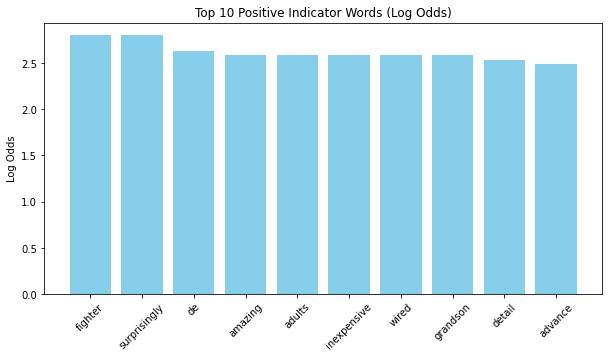

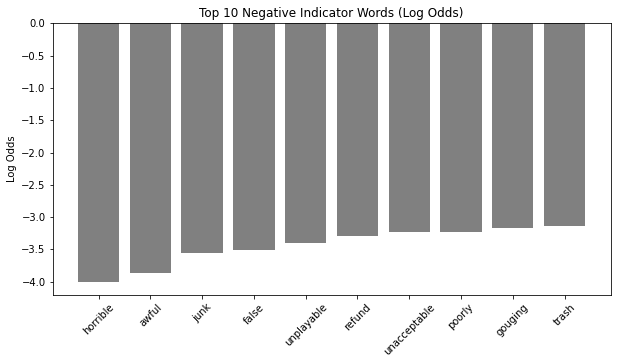

In [16]:
### Visualize Results
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,5))
    plt.bar(top_pos_words, top_pos_scores, color='skyblue')
    plt.title("Top 10 Positive Indicator Words (Log Odds)")
    plt.ylabel("Log Odds")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.bar(top_neg_words, top_neg_scores, color='gray')
    plt.title("Top 10 Negative Indicator Words (Log Odds)")
    plt.ylabel("Log Odds")
    plt.xticks(rotation=45)
    plt.show()


##### **Task 2.3**: Identify Most Confusing Words ("Ambiguous Words")
Some words may appear frequently in both positive and negative reviews, making them poor discriminators of sentiment. These are "ambiguous words."

In this task, find the top k words whose log odds ratios are closest to zero (i.e., most ambiguous).

In [17]:
### Task 2.3: Identify Most Confusing Words ("Ambiguous Words")
def find_ambiguous_words(log_odds, vocab, top_k=10):
    """
    Find the top_n words whose log odds ratio is closest to zero.
    You may need to us the function numpy.argsort().

    Args:
        log_odds: numpy array of shape (vocab_size,), log-odds for each word
        vocab: numpy array of shape (vocab_size,), vocabulary, which maps indices to words
        top_k: int, number of top ambiguous words to return

    Returns:
        ambiguous_words: list of word strings
        ambiguous_scores: list of log-odds scores
    """
    ###TODO-8###E
    idx = np.argsort(np.abs(log_odds))[:top_k]
    return vocab[idx], log_odds[idx]

if __name__ == "__main__":
    ambiguous_words, ambiguous_scores = find_ambiguous_words(log_odds, vocab)
    print(type(ambiguous_words))
    print("Most Ambiguous Words (Log Odds ~ 0):")
    for w, s in zip(ambiguous_words, ambiguous_scores):
        print(f"{w:15s}  {s:.3f}")

<class 'numpy.ndarray'>
Most Ambiguous Words (Log Odds ~ 0):
really           0.002
if               0.003
mean             -0.003
seen             -0.006
chat             0.007
werent           0.007
speed            0.007
running          0.007
generation       0.007
score            0.007


#### Part 3: Model Evaluation with Confusion Matrix

In real-world applications, accuracy alone isn't enough to evaluate a model's performance. A confusion matrix provides a more detailed breakdown of correct and incorrect predictions, allowing us to understand the types of errors our model makes.

##### Task Overview

1. (Task3.1) **Compute the confusion matrix** for your Naive Bayes classifier.
2. (Task3.2) **Calculate precision, recall, and F1-score** from the confusion matrix.


##### **Task 3.1**: Compute Confusion Matrix

Given the ground truth labels (y_true) and your model's predicted labels (y_pred), we build a (2, 2) shaped numpy array that summarizes the results of the classification including the following four values.

- **True Negatives (TN):** The number of observations correctly identified as negative.

- **False Positives (FP):** The number of observations incorrectly identified as positive.

- **False Negatives (FN):** The number of observations incorrectly identified as negative.

- **True Positives (TP):** The number of observations correctly identified as positive.

Your code will need to iterate through the lists of true and predicted labels and, for each pair, increment the corresponding counter in the confusion matrix. Remember that the matrix is structured as follows:

| | Predicted Negative (0) | Predicted Positive (1) |
|---|---|---|
| **Actual Negative (0)** | TN (`[0,0]`) | FP (`[0,1]`) |
| **Actual Positive (1)** | FN (`[1,0]`) | TP (`[1,1]`) |


Confusion Matrix:
[[237  32]
 [ 38 349]]


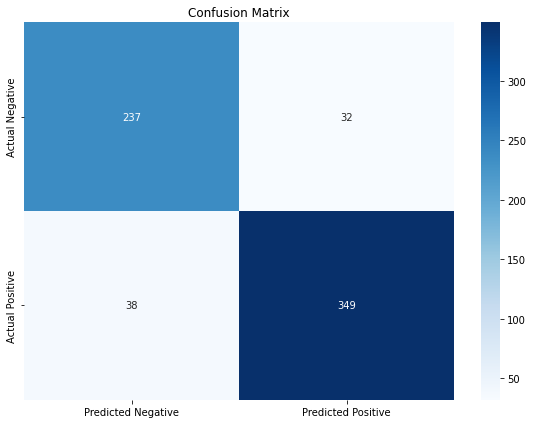

In [18]:
###Task3.1: Compute Confusion Matrix###
def compute_confusion_matrix(y_true, y_pred):
    """
    Compute the confusion matrix for binary classification.

    Args:
        y_true: numpy array of shape (n_samples,), ground truth labels
        y_pred: numpy array of shape (n_samples,), predicted labels

    Returns:
        confusion_matrix: numpy array of shape (2, 2), where:
            [0,0] = True Negatives (TN)
            [0,1] = False Positives (FP)
            [1,0] = False Negatives (FN)
            [1,1] = True Positives (TP)
    """
    ###TODO-9###E
    confusion_matrix = np.zeros((2, 2), dtype=int)

    tp = ((y_true == 1) & (y_pred == 1)).sum(axis=0)
    tn = ((y_true == 0) & (y_pred == 0)).sum(axis=0)
    fp = ((y_true == 0) & (y_pred == 1)).sum(axis=0)
    fn = ((y_true == 1) & (y_pred == 0)).sum(axis=0)

    confusion_matrix[0,0] = tn
    confusion_matrix[0,1] = fp
    confusion_matrix[1,0] = fn
    confusion_matrix[1,1] = tp

    return confusion_matrix


if __name__ == "__main__":
    # Get predictions on test data
    test_predictions = nb_classifier.predict(test_bow)

    # Compute confusion matrix
    conf_matrix = compute_confusion_matrix(test_labels, test_predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Visualize confusion matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

##### **Task 3.2**: Calculate Precision, Recall, and F1-Score

Given the confusion matrix, calculate the following metrics:

1. **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
   - $Precision = \frac{TP}{(TP + FP)}$

2. **Recall**: The ratio of correctly predicted positive observations to all actual positives. That is to calculate, of all the instances that were actually positive, what proportion did the model **correctly identify**?
   - $Recall = \frac{TP}{(TP + FN)}$

3. **F1-Score**: The harmonic mean of precision and recall. This is a balanced measure that considers both false positives and false negatives, which is particularly useful when you have an uneven class distribution.
   - $F1 = 2 \times \frac{(Precision \times Recall)}{(Precision + Recall)}$

In [19]:
###Task3.2: Calculate Precision, Recall, and F1-Score###
def calculate_metrics(confusion_matrix):
    """
    Calculate precision, recall, and F1-score from a confusion matrix.
    You may use the previous functions that we implement

    Args:
        confusion_matrix: numpy array of shape (2, 2)

    Returns:
        three values: precision, recall, and f1_score
    """
    ###TODO-10###

    tn, fp = confusion_matrix[0, 0], confusion_matrix[0, 1]
    fn, tp = confusion_matrix[1, 0], confusion_matrix[1, 1]

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

if __name__ == "__main__":
    # Get predictions on test data
    test_predictions = nb_classifier.predict(test_bow)

    # Compute confusion matrix
    conf_matrix = compute_confusion_matrix(test_labels, test_predictions)
    # Calculate metrics
    metrics = calculate_metrics(conf_matrix)
    print("\nModel Performance Metrics:")
    print(f"Precision: {metrics[0]:.4f}")
    print(f"Recall: {metrics[1]:.4f}")
    print(f"F1-Score: {metrics[2]:.4f}")


Model Performance Metrics:
Precision: 0.9160
Recall: 0.9018
F1-Score: 0.9089


##### Remember to put any debugging code under: 
```
if __name__ == "__main__": 
```
##### to avoid any erros while testing on ZINC!